In [ ]:
!pip install emoji
!pip install vaderSentiment

In [ ]:
import numpy as np
import emoji
import pandas as pd
import collections
import seaborn as sns
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string

In [ ]:
df_anger_train = pd.read_csv("anger-ratings-0to1.train.txt", sep="\t",error_bad_lines=False)
df_anger_test = pd.read_csv("anger-ratings-0to1.dev.gold.txt", sep="\t",error_bad_lines=False)
df_anger_train.columns = ['index','tweet','sentiment','score']
df_anger_test.columns = ['index','tweet','sentiment','score']

df_joy_train =  pd.read_csv("joy-ratings-0to1.train.txt", sep="\t",error_bad_lines=False)
df_joy_test =  pd.read_csv("joy-ratings-0to1.test.gold.txt", sep="\t",error_bad_lines=False)
df_joy_train.columns = ['index','tweet','sentiment','score']
df_joy_test.columns = ['index','tweet','sentiment','score']


df_train = pd.concat([df_anger_train,df_joy_train])
df_test = pd.concat([df_anger_test,df_joy_test])

df_train= df_train.reset_index()
df_test= df_test.reset_index()

df_train =df_train[['index','tweet','sentiment','score']]
df_test =df_test[['index','tweet','sentiment','score']]
df_train.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,index,tweet,sentiment,score
0,10001,So my Indian Uber driver just called someone t...,anger,0.896
1,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
2,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
3,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
4,10005,My blood is boiling,anger,0.875


In [ ]:
df_test.head()

,index,tweet,sentiment,score
0,10858,@ArcticFantasy I would have almost took offens...,anger,0.458
1,10859,@IllinoisLoyalty that Rutgers game was an abom...,anger,0.562
2,10860,@CozanGaming that's what lisa asked before she...,anger,0.500
3,10861,Sometimes I get mad over something so minuscul...,anger,0.708
4,10862,Sometimes I get mad over something so minuscul...,anger,0.646


In [ ]:
df_joy_train.iloc[0]['tweet']

In [ ]:
df_joy_test.iloc[1]['tweet']

In [ ]:
ctr = collections.Counter()
for r in df_train["tweet"]:
    ctr.update(r.split(" "))
test = pd.DataFrame.from_dict(ctr, orient='index').reset_index()
test.columns = ['words','count']
test = test.sort_values('count', ascending = False)
test.tail()

,words,count
1506,annoyed/sad,1
1508,itself,1
1509,ground,1
1510,🙄🙄,1
7886,death.,1


In [ ]:
test.shape[0]

Removal of @mentions, urls

In [ ]:
# Check for http,www,url links
filter = df_train['tweet'].str.contains('http')
df_train[filter]

In [ ]:
t = df_train[df_train['index'] == 10060]
t.iloc[0][1]

'@lynnew69 then he said talking about wills uncontrollable animals when moving to another link. These comments do not help! #fuming'

We will remove:

- Mentions @
- URL's (if any)
- Punctuations
- Lower case all words
- Hastag Segmentation
- Make elongated words to normal**{Not Done Yet}**
- convert emojis to understandable form

In [ ]:
def preprocessing(df):
    texts = []
    all_hashtaged_word_list = []
    for i in range(df.shape[0]):
        old_text = df.iloc[i][1]
        list_of_words = old_text.split()
        hashtaged_words = []
        for word in list_of_words:
            if word.startswith("#"):
                hashtaged_words.append(word)
        old_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", old_text).split())
        old_text = ' '.join(re.sub("(\w+:\/\/\S+)", " ", old_text).split())
        old_text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", old_text).split())
        old_text = old_text.replace("[","")
        old_text = old_text.replace("]","")
        old_text = old_text.replace("(","")
        old_text = old_text.replace(")","")
        old_text = old_text.replace("{","")
        old_text = old_text.replace("}","")
        old_text = old_text.replace("_","")
        old_text = old_text.replace("*","")
        old_text = old_text.replace("*","")
        old_text = old_text.replace("&","")
        old_text = old_text.lower()
        old_text = emoji.demojize(old_text)
        old_text = old_text.replace(":"," ")
        old_text = old_text.replace("\\n","")
        old_text = old_text.replace("//","")
        old_text = old_text.replace("')","")
        old_text = ' '.join(old_text.split())
        for character in string.punctuation:
            old_text = old_text.replace(character, '')
        my_list = ['' if i in ['[',']','(',')',"'",'*','&','{','}',"' )","')"] else i for i in list(old_text)]
        new_text = ''.join(map(str,my_list))
        texts.append(new_text)
        all_hashtaged_word_list.append(hashtaged_words)
    return texts,all_hashtaged_word_list

texts,all_hashtaged_word_list = preprocessing(df_train)
COLUMN_NAMES =  ['index','tweet','sentiment','score']
df_train_1 = pd.DataFrame(columns=COLUMN_NAMES)
df_train_1['index'] = df_train['index']
df_train_1['sentiment'] = df_train['sentiment']
df_train_1['score'] = df_train['score']
df_train_1['tweet'] = texts
df_train_1['all_hashtaged_words'] = all_hashtaged_word_list
df_train = df_train_1.copy()
df_train.head()

In [ ]:
new_hashtaged_words = []
for lis in df_train['all_hashtaged_words']:
    hw = []
    for word in lis:
        word = word[1:]
        hw.append(word)
    new_hashtaged_words.append(hw)
df_train['all_hashtaged_words'] = new_hashtaged_words

In [ ]:
ctr = collections.Counter()
for r in df_train["tweet"]:
    ctr.update(r.split(" "))
test = pd.DataFrame.from_dict(ctr, orient='index').reset_index()
test.columns = ['words','count']
test = test.sort_values('count', ascending = False)
test.tail()

In [ ]:
test.shape[0]

4705

Hence we reduced the vocaubulary size from 7887 to 4705

Similarly for Test Data

In [ ]:
texts,all_hashtaged_word_list = preprocessing(df_test)
COLUMN_NAMES =  ['index','tweet','sentiment','score']
df_test_1 = pd.DataFrame(columns=COLUMN_NAMES)
df_test_1['index'] = df_test['index']
df_test_1['sentiment'] = df_test['sentiment']
df_test_1['score'] = df_test['score']
df_test_1['tweet'] = texts
df_test_1['all_hashtaged_words'] = all_hashtaged_word_list
df_test = df_test_1.copy()
df_test.head()

new_hashtaged_words = []
for lis in df_test['all_hashtaged_words']:
    hw = []
    for word in lis:
        word = word[1:]
        hw.append(word)
    new_hashtaged_words.append(hw)
df_test['all_hashtaged_words'] = new_hashtaged_words

ctr = collections.Counter()
for r in df_test["tweet"]:
    ctr.update(r.split(" "))
test = pd.DataFrame.from_dict(ctr, orient='index').reset_index()
test.columns = ['words','count']
test = test.sort_values('count', ascending = False)
test.tail()

test.shape[0]

2900

Computing Vander Sentiment(Valence Aware Dictionary and sEntiment Reasoner)
- Its a rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
- The Compound/Overall score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).
    - positive sentiment : (compound score >= 0.05) 
    - neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 

    - negative sentiment : (compound score <= -0.05)

In [ ]:
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return (sentiment_dict['pos'],sentiment_dict['neg'],sentiment_dict['neu'],sentiment_dict['compound'])

def getVanderSentiment(df):
    postive_score = []
    negative_score = []
    neural_score = []
    overall_score = []
    for text in df['tweet']:
        pos,neg,neu,over = sentiment_scores(text)
        postive_score.append(pos)
        negative_score.append(neg)
        neural_score.append(neu)
        overall_score.append(over)
    return (postive_score,negative_score,neural_score,overall_score)


postive_score,negative_score,neural_score,overall_score = getVanderSentiment(df_train)
COLUMN_NAMES =  ['index','tweet','sentiment','score',"all_hashtaged_words",'VanderSentiment_pos','VanderSentiment_neg','VanderSentiment_neu','VanderSentiment_overall']
df_train_1 = pd.DataFrame(columns=COLUMN_NAMES)
df_train_1['index'] = df_train['index']
df_train_1['sentiment'] = df_train['sentiment']
df_train_1['all_hashtaged_words'] = df_train['all_hashtaged_words']
df_train_1['score'] = df_train['score']
df_train_1['tweet'] = df_train['tweet']
df_train_1['VanderSentiment_pos'] = postive_score
df_train_1['VanderSentiment_neg'] = negative_score
df_train_1['VanderSentiment_neu'] = neural_score
df_train_1['VanderSentiment_overall'] = overall_score
df_train = df_train_1.copy()
df_train.head()

In [ ]:
postive_score,negative_score,neural_score,overall_score = getVanderSentiment(df_test)
COLUMN_NAMES =  ['index','tweet','sentiment','score',"all_hashtaged_words",'VanderSentiment_pos','VanderSentiment_neg','VanderSentiment_neu','VanderSentiment_overall']
df_test_1 = pd.DataFrame(columns=COLUMN_NAMES)
df_test_1['index'] = df_test['index']
df_test_1['sentiment'] = df_test['sentiment']
df_test_1['all_hashtaged_words'] = df_test['all_hashtaged_words']
df_test_1['score'] = df_test['score']
df_test_1['tweet'] = df_test['tweet']
df_test_1['VanderSentiment_pos'] = postive_score
df_test_1['VanderSentiment_neg'] = negative_score
df_test_1['VanderSentiment_neu'] = neural_score
df_test_1['VanderSentiment_overall'] = overall_score
df_test = df_test_1.copy()
df_test.head()

Polar Word Count using MPQA_Subjectivity_lexicon_dict

In [ ]:
df_mpqa = pd.read_csv('MPQA_Subjectivity_lexicon_dict_sentimentDict.csv')
df_mpqa.tail()

In [ ]:
df_mpqa['polarity'].unique()

In [ ]:
def MPQA_Subjectivity_lexicon_dict(df):
    word_list = []
    for i in range(df.shape[0]):
        tweet = df['tweet'][i] 
        for words in tweet.split(" "):
            word_list.append(words)

    print(len(word_list))
    word_set = set(word_list)
    word_list = list(word_set)
    print(len(word_list))
    print(df['tweet'][i])
    stype = []
    count = 0
    short_word_list = []
    for word in word_list:
        t = word
        filter= df_mpqa['word'] == t
        mel_count = df_mpqa[filter].shape[0]
        if mel_count>0:
            short_word_list.append(word)
            stype.append(df_mpqa[filter][:])
    print(len(stype))
    df_short_mpqa = pd.concat(stype)
    dictionary = {}
    for word in short_word_list:
        for i in range(df_short_mpqa.shape[0]):
            if word == df_short_mpqa.iloc[i][2]:
                if df_short_mpqa.iloc[i][5] == 'positive':
                    dictionary[word] = 'positive'
                elif df_short_mpqa.iloc[i][5] == 'negative':
                    dictionary[word] = 'negative'
                elif df_short_mpqa.iloc[i][5] == 'neutral':
                    dictionary[word] = 'neutral'
    positive_count = []
    negative_count = []
    for text in df['tweet']:
        lis_text = text.split(" ")
        pc = 0
        nc = 0
        for t in lis_text:
            if t in dictionary:
                if dictionary[t] == 'positive':
                    pc = pc + 1
                elif dictionary[t] == 'negative':
                    nc = nc + 1
        positive_count.append(pc)
        negative_count.append(nc)
    print(len(positive_count))
    print(len(negative_count))
    return positive_count, negative_count

In [ ]:
positive_count, negative_count = MPQA_Subjectivity_lexicon_dict(df_train)

In [ ]:
df_train['polar_word_count_pos'] = positive_count 
df_train['polar_word_count_neg'] = negative_count 
df_train.head(1)

In [ ]:
positive_count, negative_count = MPQA_Subjectivity_lexicon_dict(df_test)
df_test['polar_word_count_pos'] = positive_count 
df_test['polar_word_count_neg'] = negative_count 
df_test.head(2)

Polar word count: Count of positive
and negative words using the MPQA
subjectivity lexicon
Polar word count is 0 for words if they dont appear in the lexicon.


- Aggregate polarity scores using Sentinent140 lexicon

In [ ]:
df_sentinent140 = pd.read_csv("unigrams-pmilexicon.txt", sep="\t",error_bad_lines=False)
df_sentinent140.columns = ['unigram','score','numPos','numNeg']

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_afinn = pd.read_csv('AFINN-111.txt',sep="\t",error_bad_lines=False)
df_afinn.columns = ['term','score_on_postive_or_negative']
df_afinn.head()

,term,score_on_postive_or_negative
0,abandoned,-2
1,abandons,-2
2,abducted,-2
3,abduction,-2
4,abductions,-2


In [ ]:
df_sentinent140.head()
df_sentinent140_unigrams = list(df_sentinent140['unigram'])
df_sentinent140_score = list(df_sentinent140['score'])

In [ ]:
def polarity_scores(df):
    word_list = []
    for i in range(df.shape[0]):
        tweet = df['tweet'][i] 
        for words in tweet.split(" "):
            word_list.append(words)

    print(len(word_list))
    word_set = set(word_list)
    word_list = list(word_set)
    print(len(word_list))
    short_words = []
    df_sentinent140_unigrams_short = []
    df_sentinent140_score_short = []
    for word in word_list:
        if word in df_sentinent140_unigrams:
            short_words.append(word)
            df_sentinent140_unigrams_short.append(word)
            index = df_sentinent140_unigrams.index(word)
            df_sentinent140_score_short.append(df_sentinent140_score[index])
    dictionary = {}
    for word in short_words:
            index = df_sentinent140_unigrams_short.index(word)
            dictionary[word] = df_sentinent140_score_short[index]
    afinn_terms = list(df_afinn['term'])
    score_on_postive_or_negative = list(df_afinn['score_on_postive_or_negative'])
    scores = []
    for text in df['tweet']:
        lis_text = text.split(" ")
        for t in lis_text:
            sum = 0
            count = 1
            if t in dictionary:
                sum = dictionary[t] + sum 
            if t in afinn_terms:
                index = afinn_terms.index(t)
                s = score_on_postive_or_negative[index]
                sum = sum + s
        scores.append(sum)
    print(len(scores))
    return scores

df_train['Sentinent140_scores'] = polarity_scores(df_train)
df_train.head(2)

In [ ]:
df_test['Sentinent140_scores'] = polarity_scores(df_test)
df_test.head(2)

11754
2900
796


,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,Sentinent140_scores
0,10858,i would have almost took offense to this if i ...,anger,0.458,[],0.000,0.125,0.875,-0.1832,0,0,0.676
1,10859,that rutgers game was an abomination an affron...,anger,0.562,[],0.104,0.000,0.896,0.2732,0,3,-0.286


- – Aggregate polarity scores (Hashtags):

In [ ]:
df_hashtag_polarity = pd.read_csv('sentimenthashtags.txt',sep="\t",error_bad_lines=False)
df_hashtag_polarity.columns = ['word','sentiment']
df_hashtag_polarity.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,word,sentiment
0,good,positive
1,great,positive
2,excellent,positive
3,excellence,positive
4,fine,positive


In [ ]:
df_train.head(1)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,Sentinent140_scores
0,10001,so my indian uber driver just called someone t...,anger,0.896,[disgusted],0.0,0.0,1.0,0.0,2,0,0.0


– Aggregate polarity scores (Hashtags):
Aggregate of positive and negative
scores of the hashtags in a tweet is calculated from NRC Hashtag Sentiment
lexicon

In [ ]:
def hashtag_polarity(df):
    hashtag_polarity_words = list(df_hashtag_polarity['word'])
    hashtag_polarity_sentiment = list(df_hashtag_polarity['sentiment'])
    hashtag_polarity = []
    for hashtag_list in df['all_hashtaged_words']:
        positive_count = 0
        negative_count = 0 
        for hashtag in hashtag_list:
            if hashtag in hashtag_polarity_words:
                index = hashtag_polarity_words.index(hashtag) 
                sentiment = hashtag_polarity_sentiment[index]
                if sentiment == 'positive':
                    positive_count = positive_count + 1
                elif sentiment == 'negative':
                    negative_count = negative_count + 1
        if positive_count > negative_count:
            hashtag_polarity.append('positive')
        elif positive_count < negative_count:
            hashtag_polarity.append('negative')
        else:
            hashtag_polarity.append('neural')
    return hashtag_polarity
df_train['hashtag_polarity'] = hashtag_polarity(df_train)
df_train.head(2)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,Sentinent140_scores,hashtag_polarity
0,10001,so my indian uber driver just called someone t...,anger,0.896,[disgusted],0.0,0.0,1.0,0.0,2,0,0.0,neural
1,10002,uk i asked for my parcel to be delivered to a ...,anger,0.896,"[fuming, poorcustomerservice]",0.0,0.0,1.0,0.0,0,0,0.0,neural


In [ ]:
df_test['hashtag_polarity'] = hashtag_polarity(df_test)
df_test.head(2)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,Sentinent140_scores,hashtag_polarity
0,10858,i would have almost took offense to this if i ...,anger,0.458,[],0.000,0.125,0.875,-0.1832,0,0,0.676,neural
1,10859,that rutgers game was an abomination an affron...,anger,0.562,[],0.104,0.000,0.896,0.2732,0,3,-0.286,neural


- Emotion word count:

In [ ]:
df_Word_Emotion_Association_Lexicon = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',sep="\t",error_bad_lines=False)
df_Word_Emotion_Association_Lexicon.columns = ['term','affectcategory','associationflag']
df_Word_Emotion_Association_Lexicon = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['associationflag'] == 1]
df_Word_Emotion_Association_Lexicon.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,term,affectcategory,associationflag
18,abacus,trust,1
22,abandon,fear,1
24,abandon,negative,1
26,abandon,sadness,1
29,abandoned,anger,1


In [ ]:
df_Word_Emotion_Association_Lexicon['affectcategory'].unique() # 10 columns

array(['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise',
       'positive', 'disgust', 'joy', 'anticipation'], dtype=object)

In [ ]:
df_anticipation = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'anticipation']
list_of_terms_with_anticipation = list(set(list(df_anticipation['term'])))
df_disgust = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'disgust']
list_of_terms_with_disgust = list(set(list(df_disgust['term'])))
df_fear = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'fear']
list_of_terms_with_fear = list(set(list(df_fear['term'])))
df_joy = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'joy']
list_of_terms_with_joy = list(set(list(df_joy['term'])))
df_negative = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'negative']
list_of_terms_with_negative = list(set(list(df_negative['term'])))
df_positive = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'positive']
list_of_terms_with_positive = list(set(list(df_positive['term'])))
df_sadness = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'sadness']
list_of_terms_with_sadness = list(set(list(df_sadness['term'])))
df_surprise = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'surprise']
list_of_terms_with_surprise = list(set(list(df_surprise['term'])))
df_trust = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'trust']
list_of_terms_with_trust = list(set(list(df_trust['term'])))
df_anger = df_Word_Emotion_Association_Lexicon[df_Word_Emotion_Association_Lexicon['affectcategory'] == 'anger']
list_of_terms_with_anger = list(set(list(df_anger['term'])))

In [ ]:
def Word_Emotion_Association_Lexicon(df):
    scores = []
    a = []
    d = []
    f = []
    j = []
    n = []
    p = []
    s = []
    su = []
    tw = []
    an = []
    for text in df['tweet']:
        lis_text = text.split(" ")
        a1 = 0
        d1 = 0
        f1 = 0
        j1 = 0
        n1 = 0
        p1 = 0
        s1 = 0
        su1 = 0
        t1 = 0
        an1 = 0
        for t in lis_text:
            if t in list_of_terms_with_anticipation:
                a1 = a1 + 1
            if t in list_of_terms_with_disgust:
                d1 = d1 + 1
            if t in list_of_terms_with_fear:
                f1 = f1 + 1
            if t in list_of_terms_with_joy:
                j1 = j1 + 1
            if t in list_of_terms_with_negative:
                n1 = n1 + 1
            if t in list_of_terms_with_positive:
                p1 = p1 + 1
            if t in list_of_terms_with_sadness:
                s1 = s1 + 1
            if t in list_of_terms_with_surprise:
                su1 = su1 + 1
            if t in list_of_terms_with_trust:
                t1 = t1 + 1
            if t in list_of_terms_with_anger:
                an1 = an1 + 1
        a.append(a1)
        d.append(d1)
        f.append(f1)
        j.append(j1)
        n.append(n1)
        p.append(p1)
        s.append(s1)
        su.append(su1)
        tw.append(t1)
        an.append(an1)
    df['emotion_word_count_anticipation'] = a
    df['emotion_word_count_disgust'] = d
    df['emotion_word_count_fear'] = f
    df['emotion_word_count_joy'] = j
    df['emotion_word_count_negative'] = n
    df['emotion_word_count_positive'] = p
    df['emotion_word_count_sadness'] = s
    df['emotion_word_count_surprise'] = su
    df['emotion_word_count_trust'] = tw
    df['emotion_word_count_anger'] = an
    return df
df_train = Word_Emotion_Association_Lexicon(df_train)
df_train.head(2)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,...,emotion_word_count_anticipation,emotion_word_count_disgust,emotion_word_count_fear,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger
0,10001,so my indian uber driver just called someone t...,anger,0.896,[disgusted],0.0,0.0,1.0,0.0,2,...,0,0,0,0,0,1,0,0,1,0
1,10002,uk i asked for my parcel to be delivered to a ...,anger,0.896,"[fuming, poorcustomerservice]",0.0,0.0,1.0,0.0,0,...,1,0,0,0,0,2,0,0,0,0


In [ ]:
df_test = Word_Emotion_Association_Lexicon(df_test)
df_test.head(2)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,...,emotion_word_count_anticipation,emotion_word_count_disgust,emotion_word_count_fear,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger
0,10858,i would have almost took offense to this if i ...,anger,0.458,[],0.000,0.125,0.875,-0.1832,0,...,0,1,1,0,1,0,1,0,0,1
1,10859,that rutgers game was an abomination an affron...,anger,0.562,[],0.104,0.000,0.896,0.2732,0,...,1,2,3,1,2,1,1,1,1,2


Aggregate emotion score (Hashtags): NRC
Hashtag Emotion Association Lexicon

In [ ]:
df_hashtag_emotion_lexicon = pd.read_csv('NRC-Hashtag-Emotion-Lexicon-v0.2.txt',sep="\t",error_bad_lines=False)
df_hashtag_emotion_lexicon.columns = ['term','affectcategory','associationflag']
df_hashtag_emotion_lexicon.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,term,affectcategory,associationflag
0,anticipation,#mycolour,2.237478
1,anticipation,#vigilance,2.237478
2,anticipation,#vigilant,2.237478
3,anticipation,#hmmmmm,2.237478
4,anticipation,aroused,2.237478


In [ ]:
new_affect_category = []
for ac in df_hashtag_emotion_lexicon['affectcategory']:
    if type(ac) == str:
        text = ac[1:]
    else:
        text = ac
    new_affect_category.append(text)
df_hashtag_emotion_lexicon['affectcategory'] = new_affect_category
df_hashtag_emotion_lexicon.head()

,term,affectcategory,associationflag
0,anticipation,mycolour,2.237478
1,anticipation,vigilance,2.237478
2,anticipation,vigilant,2.237478
3,anticipation,hmmmmm,2.237478
4,anticipation,roused,2.237478


In [ ]:
len(df_hashtag_emotion_lexicon['affectcategory'].unique())

13639

In [ ]:
len(df_hashtag_emotion_lexicon['term'].unique())

8

In [ ]:
df_train.head(1)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,...,emotion_word_count_anticipation,emotion_word_count_disgust,emotion_word_count_fear,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger
0,10001,so my indian uber driver just called someone t...,anger,0.896,[disgusted],0.0,0.0,1.0,0.0,2,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
def hashtag_emotion_lexicon(df):
    all_hashtag_words = list(df['all_hashtaged_words'])
    associationflag = list(df_hashtag_emotion_lexicon['associationflag'])
    hashtag_emotion_lexicon_words = list(df_hashtag_emotion_lexicon['affectcategory'])
    score_hashtag_emotion_lexicon = []
    for hashtag_list in df['all_hashtaged_words']:
        sum = 0
        for hashtag in hashtag_list:
            if hashtag in hashtag_emotion_lexicon_words:
                index = hashtag_emotion_lexicon_words.index(hashtag) 
                score = associationflag[index]
                sum = sum + score
        score_hashtag_emotion_lexicon.append(sum)
    return score_hashtag_emotion_lexicon
df_train['score_hashtag_emotion_lexicon'] = hashtag_emotion_lexicon(df_train)
df_train.head(2)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,...,emotion_word_count_disgust,emotion_word_count_fear,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon
0,10001,so my indian uber driver just called someone t...,anger,0.896,[disgusted],0.0,0.0,1.0,0.0,2,...,0,0,0,0,1,0,0,1,0,1.734578
1,10002,uk i asked for my parcel to be delivered to a ...,anger,0.896,"[fuming, poorcustomerservice]",0.0,0.0,1.0,0.0,0,...,0,0,0,0,2,0,0,0,0,1.275765


In [ ]:
df_test['score_hashtag_emotion_lexicon'] = hashtag_emotion_lexicon(df_test)
df_test.head(2)

,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,...,emotion_word_count_disgust,emotion_word_count_fear,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon
0,10858,i would have almost took offense to this if i ...,anger,0.458,[],0.000,0.125,0.875,-0.1832,0,...,1,1,0,1,0,1,0,0,1,0.0
1,10859,that rutgers game was an abomination an affron...,anger,0.562,[],0.104,0.000,0.896,0.2732,0,...,2,3,1,2,1,1,1,1,2,0.0


- Emoticons score

In [ ]:
df_afinn = pd.read_csv('AFINN-111.txt',sep="\t",error_bad_lines=False)
df_afinn.columns = ['term','score_on_postive_or_negative']
df_afinn.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,term,score_on_postive_or_negative
0,abandoned,-2
1,abandons,-2
2,abducted,-2
3,abduction,-2
4,abductions,-2


In [ ]:
def afinn(df):
    afinn_terms = list(df_afinn['term'])
    score_on_postive_or_negative = list(df_afinn['score_on_postive_or_negative'])
    scores = []
    for text in df['tweet']:
        lis_text = text.split(" ")
        for t in lis_text:
            sum = 0
            if t in afinn_terms:
                index = afinn_terms.index(t)
                s = score_on_postive_or_negative[index]
                sum = sum + s
        scores.append(sum)
    print(len(scores))
    return scores
df_train['emoticons_score'] = afinn(df_train)
df_train.head(2)

1678


,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,...,emotion_word_count_fear,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon,emoticons_score
0,10001,so my indian uber driver just called someone t...,anger,0.896,[disgusted],0.0,0.0,1.0,0.0,2,...,0,0,0,1,0,0,1,0,1.734578,0
1,10002,uk i asked for my parcel to be delivered to a ...,anger,0.896,"[fuming, poorcustomerservice]",0.0,0.0,1.0,0.0,0,...,0,0,0,2,0,0,0,0,1.275765,0


In [ ]:
def afinn(df):
    afinn_terms = list(df_afinn['term'])
    score_on_postive_or_negative = list(df_afinn['score_on_postive_or_negative'])
    scores = []
    for text in df['tweet']:
        lis_text = text.split(" ")
        for t in lis_text:
            sum = 0
            if t in afinn_terms:
                index = afinn_terms.index(t)
                s = score_on_postive_or_negative[index]
                sum = sum + s
        scores.append(sum)
    print(len(scores))
    return scores
df_test['emoticons_score'] = afinn(df_test)
df_test.head(2)

796


,index,tweet,sentiment,score,all_hashtaged_words,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,...,emotion_word_count_fear,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon,emoticons_score
0,10858,i would have almost took offense to this if i ...,anger,0.458,[],0.000,0.125,0.875,-0.1832,0,...,1,0,1,0,1,0,0,1,0.0,0
1,10859,that rutgers game was an abomination an affron...,anger,0.562,[],0.104,0.000,0.896,0.2732,0,...,3,1,2,1,1,1,1,2,0.0,0


How to find negation words is not provided in the paper ?

In [ ]:
df_train.to_csv('final_train.csv')

In [ ]:
df_test.to_csv('final_test.csv')

### Model Creation

In [ ]:
df_train = pd.read_csv('final_train.csv')
df_test = pd.read_csv('final_test.csv')
category1 = [0,1,2] # neutral, positive, negative
def get_numeric_hastag_polarity(df):
    numerical_representation_hastag_polarity = []
    for i in range(df.shape[0]):
        if df.iloc[i]['hashtag_polarity'] == 'neural':
            numerical_representation_hastag_polarity.append(0)
        elif df.iloc[i]['hashtag_polarity'] == 'positive':
            numerical_representation_hastag_polarity.append(1)
        elif df.iloc[i]['hashtag_polarity'] == 'negative':
            numerical_representation_hastag_polarity.append(2)
    return numerical_representation_hastag_polarity

df_train['numerical_hashtag_polarity'] = get_numeric_hastag_polarity(df_train)
df_train = df_train[['index','tweet','all_hashtaged_words','score','VanderSentiment_pos','VanderSentiment_neg','VanderSentiment_neu','VanderSentiment_overall',
    'polar_word_count_pos','polar_word_count_neg','Sentinent140_scores','emotion_word_count_anticipation','emotion_word_count_disgust',
    'emotion_word_count_fear', 'emotion_word_count_joy','emotion_word_count_negative', 'emotion_word_count_positive',
    'emotion_word_count_sadness', 'emotion_word_count_surprise','emotion_word_count_trust', 'emotion_word_count_anger',
    'score_hashtag_emotion_lexicon', 'emoticons_score','numerical_hashtag_polarity','sentiment']]
df_train.head(1)

,index,tweet,all_hashtaged_words,score,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,...,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon,emoticons_score,numerical_hashtag_polarity,sentiment
0,10001,so my indian uber driver just called someone t...,['disgusted'],0.896,0.0,0.0,1.0,0.0,2,0,...,0,1,0,0,1,0,1.734578,0,0,anger


In [ ]:
df_test['numerical_hashtag_polarity'] = get_numeric_hastag_polarity(df_test)
df_test = df_test[['index','tweet','all_hashtaged_words','score','VanderSentiment_pos','VanderSentiment_neg','VanderSentiment_neu','VanderSentiment_overall',
    'polar_word_count_pos','polar_word_count_neg','Sentinent140_scores','emotion_word_count_anticipation','emotion_word_count_disgust',
    'emotion_word_count_fear', 'emotion_word_count_joy','emotion_word_count_negative', 'emotion_word_count_positive',
    'emotion_word_count_sadness', 'emotion_word_count_surprise','emotion_word_count_trust', 'emotion_word_count_anger',
    'score_hashtag_emotion_lexicon', 'emoticons_score','numerical_hashtag_polarity','sentiment']]
df_test.head(1)

,index,tweet,all_hashtaged_words,score,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,...,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon,emoticons_score,numerical_hashtag_polarity,sentiment
0,10858,i would have almost took offense to this if i ...,[],0.458,0.0,0.125,0.875,-0.1832,0,0,...,1,0,1,0,0,1,0.0,0,0,anger


In [ ]:
df_train.shape[0]

1678

In [ ]:
df_train[['score','sentiment']].groupby('sentiment').count()

,score
sentiment,
anger,856
joy,822


In [ ]:
df_test.shape[0]

796

In [ ]:
X_train = df_train[['score','VanderSentiment_pos','VanderSentiment_neg','VanderSentiment_neu','VanderSentiment_overall',
    'polar_word_count_pos','polar_word_count_neg','Sentinent140_scores','emotion_word_count_anticipation','emotion_word_count_disgust',
    'emotion_word_count_fear', 'emotion_word_count_joy','emotion_word_count_negative', 'emotion_word_count_positive',
    'emotion_word_count_sadness', 'emotion_word_count_surprise','emotion_word_count_trust', 'emotion_word_count_anger',
    'score_hashtag_emotion_lexicon', 'emoticons_score','numerical_hashtag_polarity']]
y_train = df_train['sentiment']

In [ ]:
df_test[['score','sentiment']].groupby('sentiment').count()

In [ ]:
df_test_joy = df_test[df_test['sentiment'] == 'joy']
df_test_anger = df_test[df_test['sentiment'] == 'anger']
df_test_joy = df_test_joy.iloc[0:83][:]
print(df_test_joy.shape[0])
df_test = pd.concat([df_test_joy,df_test_anger])
df_test[['score','sentiment']].groupby('sentiment').count()

83


,score
sentiment,
anger,83
joy,83


In [ ]:
X_test = df_test[['score','VanderSentiment_pos','VanderSentiment_neg','VanderSentiment_neu','VanderSentiment_overall',
    'polar_word_count_pos','polar_word_count_neg','Sentinent140_scores','emotion_word_count_anticipation','emotion_word_count_disgust',
    'emotion_word_count_fear', 'emotion_word_count_joy','emotion_word_count_negative', 'emotion_word_count_positive',
    'emotion_word_count_sadness', 'emotion_word_count_surprise','emotion_word_count_trust', 'emotion_word_count_anger',
    'score_hashtag_emotion_lexicon', 'emoticons_score','numerical_hashtag_polarity']]
y_test = df_test['sentiment']

In [ ]:
X_train

,score,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,Sentinent140_scores,emotion_word_count_anticipation,emotion_word_count_disgust,...,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon,emoticons_score,numerical_hashtag_polarity
0,0.896,0.000,0.000,1.000,0.0000,2,0,0.000,0,0,...,0,0,1,0,0,1,0,1.734578,0,0
1,0.896,0.000,0.000,1.000,0.0000,0,0,0.000,1,0,...,0,0,2,0,0,0,0,1.275765,0,0
2,0.896,0.000,0.255,0.745,-0.5859,1,1,0.000,0,0,...,0,2,0,0,1,0,0,8.112784,0,2
3,0.896,0.000,0.196,0.804,-0.5978,0,2,0.000,1,0,...,1,0,3,0,1,1,1,1.275765,0,0
4,0.875,0.000,0.000,1.000,0.0000,0,2,-0.541,0,0,...,0,0,0,0,0,0,0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,0.058,0.144,0.244,0.611,-0.2023,1,1,-3.154,0,0,...,0,1,0,0,0,0,0,0.000000,-2,0
1674,0.040,0.000,0.383,0.617,-0.4767,0,1,-4.735,0,0,...,0,0,0,0,0,0,0,0.185969,-2,0
1675,0.040,0.286,0.141,0.573,0.4215,2,1,0.000,1,1,...,1,1,1,1,0,1,1,0.000000,0,0
1676,0.020,0.165,0.135,0.700,0.1531,1,0,0.000,1,0,...,1,0,2,0,1,1,0,0.000000,0,0


In [ ]:
X_test

,score,VanderSentiment_pos,VanderSentiment_neg,VanderSentiment_neu,VanderSentiment_overall,polar_word_count_pos,polar_word_count_neg,Sentinent140_scores,emotion_word_count_anticipation,emotion_word_count_disgust,...,emotion_word_count_joy,emotion_word_count_negative,emotion_word_count_positive,emotion_word_count_sadness,emotion_word_count_surprise,emotion_word_count_trust,emotion_word_count_anger,score_hashtag_emotion_lexicon,emoticons_score,numerical_hashtag_polarity
83,0.500,0.357,0.000,0.643,0.6124,0,0,0.000,0,0,...,0,0,0,0,0,0,0,0.545147,0,0
84,0.860,0.255,0.274,0.472,-0.0516,1,1,0.000,0,1,...,2,1,2,1,1,0,1,0.000000,0,0
85,0.521,0.306,0.000,0.694,0.2960,1,0,0.608,0,0,...,0,0,0,0,0,0,0,0.000000,0,0
86,0.042,0.284,0.219,0.498,0.3289,1,3,3.879,0,0,...,1,2,1,0,1,1,0,0.000000,2,0
87,0.417,0.452,0.000,0.548,0.5106,1,0,0.000,1,0,...,1,0,1,0,1,1,0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.562,0.000,0.091,0.909,-0.2500,3,1,-0.310,0,0,...,0,1,0,1,0,0,1,0.000000,0,0
79,0.625,0.224,0.235,0.541,0.1531,1,3,0.000,3,1,...,1,3,1,0,1,0,3,0.000000,0,0
80,0.292,0.489,0.000,0.511,0.5842,1,1,-1.148,1,1,...,1,1,1,0,1,1,1,0.000000,0,0
81,0.229,0.292,0.000,0.708,0.7469,2,1,0.000,1,0,...,1,1,1,1,0,0,0,0.000000,0,0


In [ ]:
y_train

0       anger
1       anger
2       anger
3       anger
4       anger
        ...  
1673      joy
1674      joy
1675      joy
1676      joy
1677      joy
Name: sentiment, Length: 1678, dtype: object

In [ ]:
y_test

83      joy
84      joy
85      joy
86      joy
87      joy
      ...  
78    anger
79    anger
80    anger
81    anger
82    anger
Name: sentiment, Length: 166, dtype: object

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   score                            1678 non-null   float64
 1   VanderSentiment_pos              1678 non-null   float64
 2   VanderSentiment_neg              1678 non-null   float64
 3   VanderSentiment_neu              1678 non-null   float64
 4   VanderSentiment_overall          1678 non-null   float64
 5   polar_word_count_pos             1678 non-null   int64  
 6   polar_word_count_neg             1678 non-null   int64  
 7   Sentinent140_scores              1678 non-null   float64
 8   emotion_word_count_anticipation  1678 non-null   int64  
 9   emotion_word_count_disgust       1678 non-null   int64  
 10  emotion_word_count_fear          1678 non-null   int64  
 11  emotion_word_count_joy           1678 non-null   int64  
 12  emotion_word_count_n

In [ ]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
#         numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()


In [ ]:
y_train

0       anger
1       anger
2       anger
3       anger
4       anger
        ...  
1673      joy
1674      joy
1675      joy
1676      joy
1677      joy
Name: sentiment, Length: 1678, dtype: object

In [ ]:
nb_clf = NaiveBayesClassifier()

In [ ]:
x = NaiveBayesClassifier()
x.fit(X_train, y_train)
predictions = x.predict(X_test)
x.accuracy(y_test, predictions)
y_test.value_counts(normalize=True)

joy      0.5
anger    0.5
Name: sentiment, dtype: float64

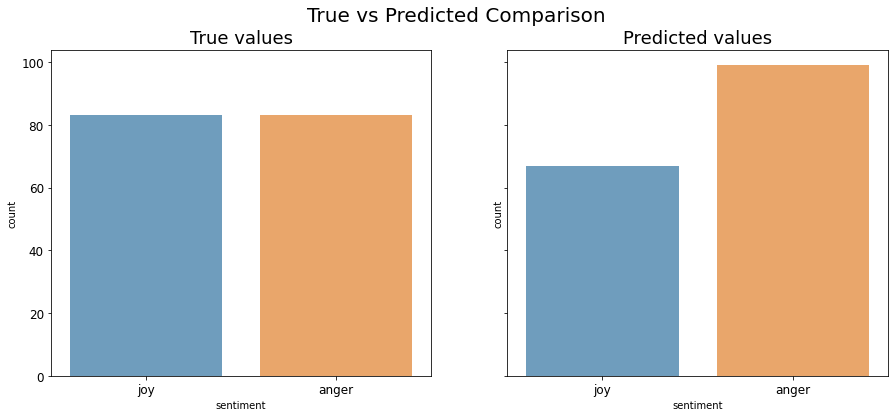

In [ ]:
tr = pd.DataFrame(data=y_test, columns=['sentiment'])
pr = pd.DataFrame(data=predictions, columns=['sentiment'])

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))

sns.countplot(x='sentiment', data=tr, ax=ax[0], alpha=0.7)
sns.countplot(x='sentiment', data=pr, ax=ax[1],  alpha=0.7)


fig.suptitle('True vs Predicted Comparison', fontsize=20)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[0].set_title("True values", fontsize=18)
ax[1].set_title("Predicted values", fontsize=18)
plt.show()

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,percent=True,
                          cbar=True,xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,cmap='Blues',title=None):

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
print(classification_report(tr, pr))

              precision    recall  f1-score   support

       anger       0.73      0.87      0.79        83
         joy       0.84      0.67      0.75        83

    accuracy                           0.77       166
   macro avg       0.78      0.77      0.77       166
weighted avg       0.78      0.77      0.77       166



In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test,predictions)
print(cf_matrix)

[[72 11]
 [27 56]]


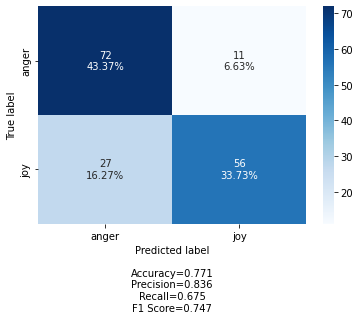

In [ ]:
categories=['anger','joy']
make_confusion_matrix(cf_matrix, group_names=categories, categories=categories, cmap='Blues')

### Using Scikit

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

clf = GaussianNB()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
clf.score(X_test, y_test)

0.7771084337349398

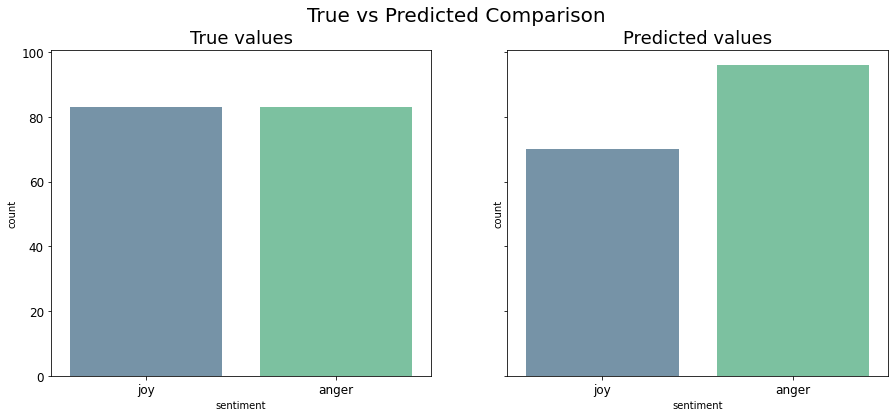

In [ ]:
tr = pd.DataFrame(data=y_test, columns=['sentiment'])
pr = pd.DataFrame(data=preds, columns=['sentiment'])

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))

sns.countplot(x='sentiment', data=tr, ax=ax[0], palette='viridis', alpha=0.7)
sns.countplot(x='sentiment', data=pr, ax=ax[1], palette='viridis', alpha=0.7)


fig.suptitle('True vs Predicted Comparison', fontsize=20)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[0].set_title("True values", fontsize=18)
ax[1].set_title("Predicted values", fontsize=18)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
#cf_matrix = confusion_matrix(y, y_pred)
cf_matrix = confusion_matrix(y_test,preds)
print(cf_matrix)

[[71 12]
 [25 58]]


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
categories=['anger','joy']

In [ ]:
print(classification_report(tr, pr))

              precision    recall  f1-score   support

       anger       0.74      0.86      0.79        83
         joy       0.83      0.70      0.76        83

    accuracy                           0.78       166
   macro avg       0.78      0.78      0.78       166
weighted avg       0.78      0.78      0.78       166



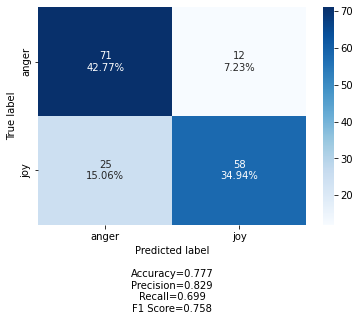

In [ ]:
make_confusion_matrix(cf_matrix, group_names=categories, categories=categories, cmap='Blues')

The Macro F1 Score on Implemented Naive Bayes Classifier was 77%

The Macro F1 Score on Scikit Implemented Naive Bayes Classifer was 78%